RED RECURRENTE PARA PREDECIR EL TIEMPO EN LA CIUDAD DE **SUCRE**

--------------------
*   Datos de entrada: 12 * 30 * 23 = 8280
12 representa las 12 horas siguiente
30 el mes 
23 la hora
*   Datos de salida: 12 (predicción de las 12 siguientes horas)



In [1]:
import numpy as np

def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
n_steps = 23
series = generate_time_series(365, n_steps + 1)
X_train, y_train = series[:255, :n_steps], series[:255, -1]
X_valid, y_valid = series[255:328, :n_steps], series[255:328, -1]
X_test, y_test = series[328:, :n_steps], series[328:, -1]
X_train.shape, y_train.shape

((255, 23, 1), (255, 1))

365 secuencias de tiempo

23 pasos de tiempo

1 dato por cada paso

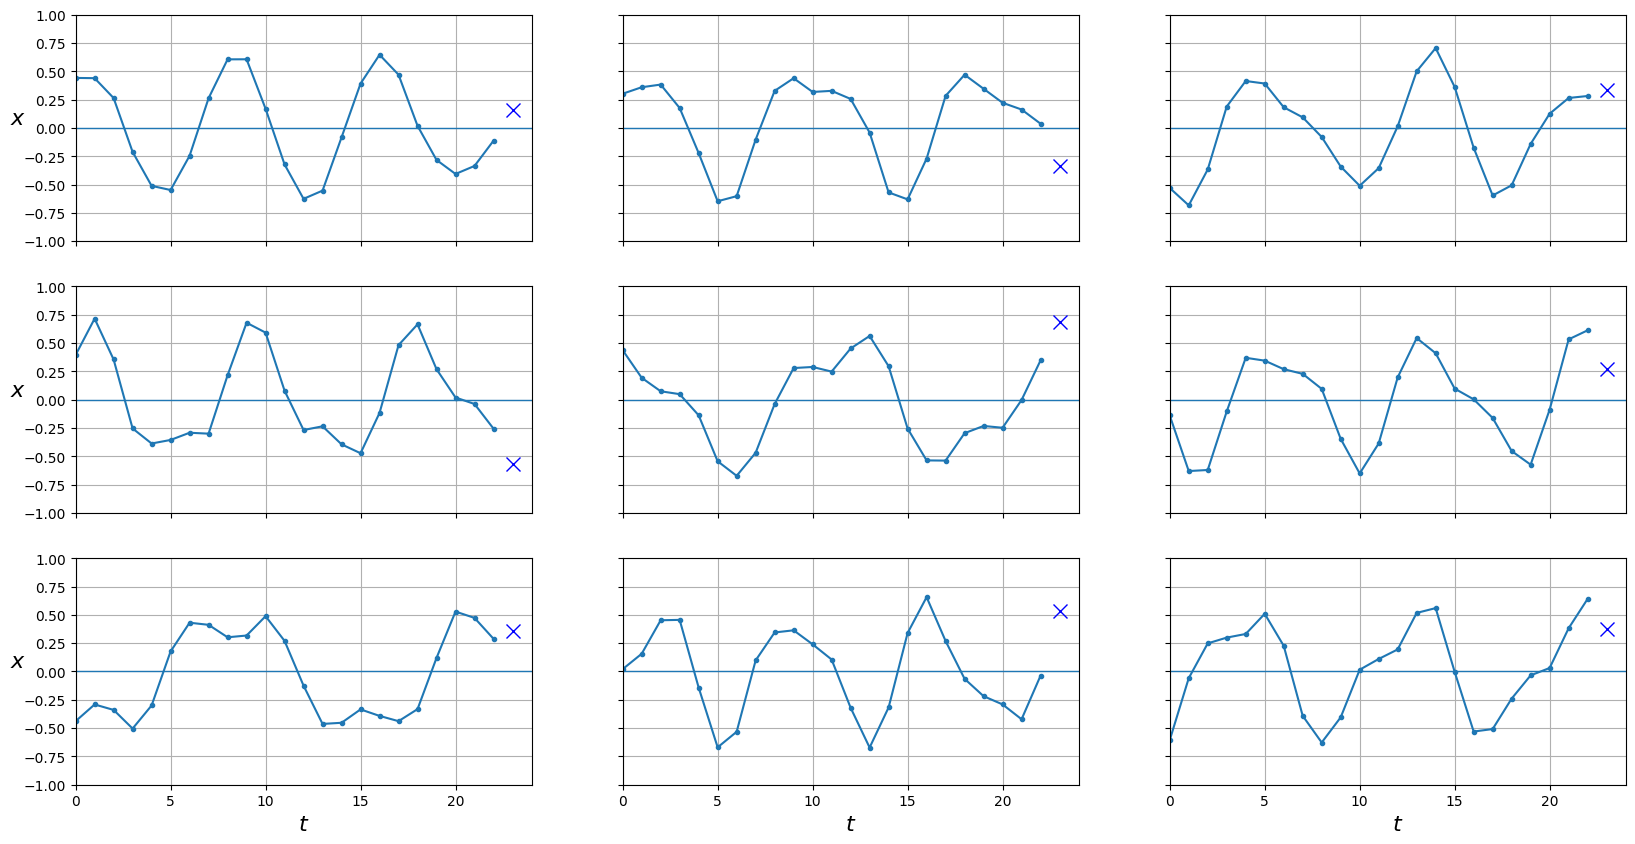

In [ ]:
import matplotlib.pyplot as plt 

def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
  r, c = 3, 3
  fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
  for row in range(r):
    for col in range(c):
        plt.sca(axes[row][col])
        ix = col + row*c
        plt.plot(series[ix, :], ".-")
        if y is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
        if y_pred is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
        if y_pred_std is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
        plt.grid(True)
        plt.hlines(0, 0, 100, linewidth=1)
        plt.axis([0, len(series[ix, :])+len(y[ix]), -1, 1])
        if x_label and row == r - 1:
          plt.xlabel(x_label, fontsize=16)
        if y_label and col == 0:
          plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.show()

plot_series(X_test, y_test)

## Transformación de Datos

Tomamos los valores máximos y mínimos de las temperaturas en sucre y creamos una función que nos permita transformar estos valores de -1 a 1 a estos valores máximo y mínimos

In [ ]:
def transformar_matriz(matriz):
    """
    Transforma una matriz tridimensional a un mínimo de 2 y un máximo de 25.

    Args:
        matriz (numpy.ndarray): Matriz tridimensional de tamaño (25, 30, 1).

    Returns:
        numpy.ndarray: Matriz transformada.
    """
    # Normalizar la matriz a un rango de 0 a 1
    matriz_normalizada = (matriz + 1) / 2

    # Escalar la matriz normalizada al rango deseado de 2 a 25
    matriz_transformada = matriz_normalizada * (25 - 2) + 2

    return matriz_transformada

In [ ]:
X_test_transformada = transformar_matriz(X_test)
y_test_transformada = transformar_matriz(y_test)

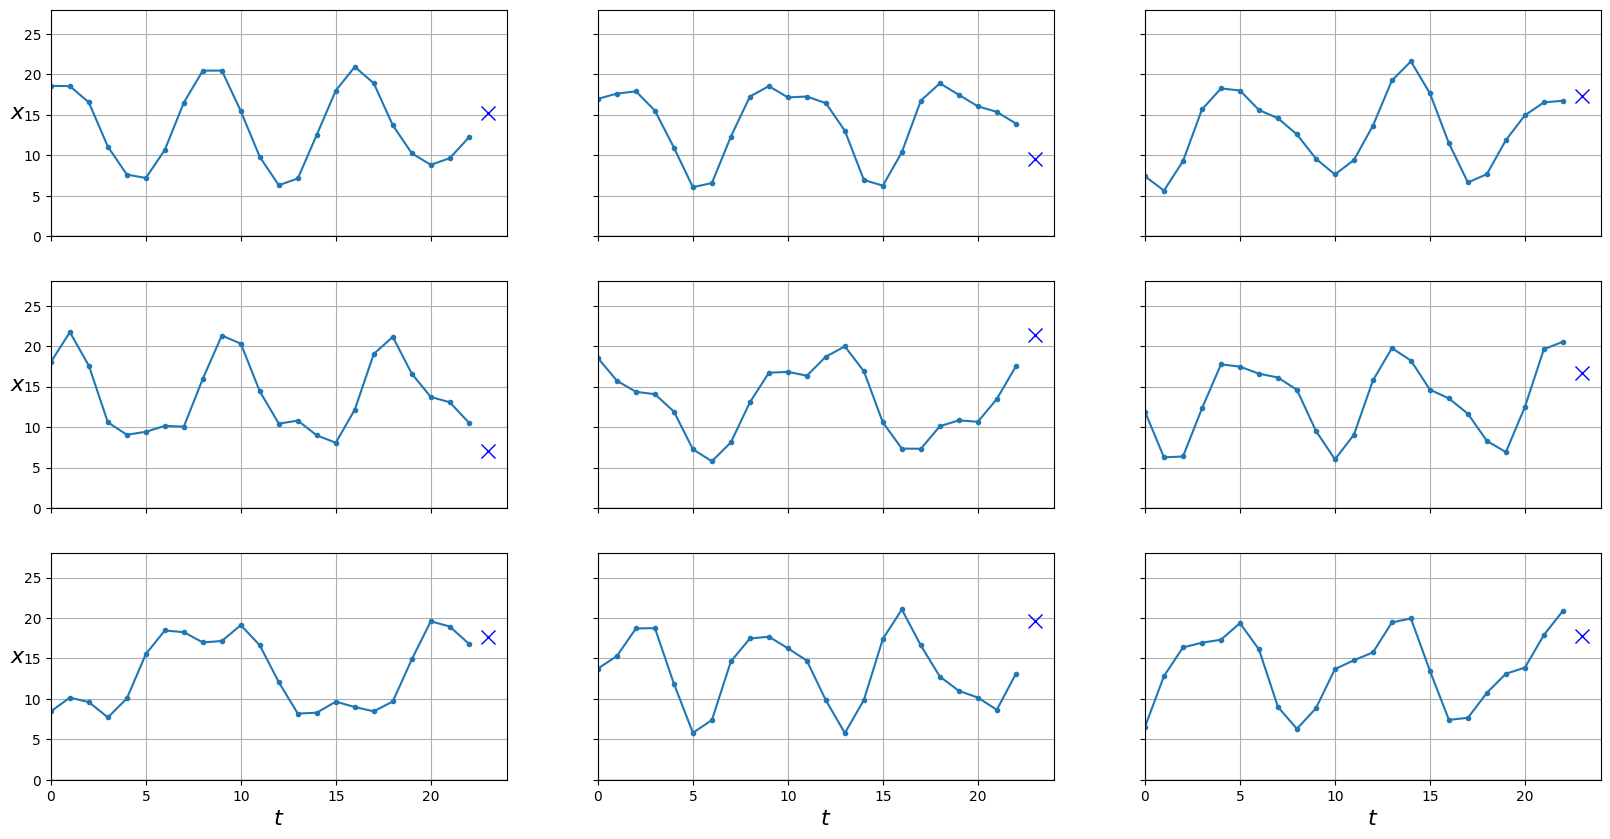

In [ ]:
import matplotlib.pyplot as plt 

def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
  r, c = 3, 3
  fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
  for row in range(r):
    for col in range(c):
        plt.sca(axes[row][col])
        ix = col + row*c
        plt.plot(series[ix, :], ".-")
        if y is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
        if y_pred is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
        if y_pred_std is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
        plt.grid(True)
        plt.hlines(0, 0, 100, linewidth=1)
        plt.axis([0, len(series[ix, :])+len(y[ix]), 0, 28])
        if x_label and row == r - 1:
          plt.xlabel(x_label, fontsize=16)
        if y_label and col == 0:
          plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.show()

plot_series(X_test_transformada, y_test_transformada)

## RNN

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
  def __init__(self, X, y=None, train=True):
    self.X = X
    self.y = y
    self.train = train

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    if self.train:
      return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
    return torch.from_numpy(self.X[ix])

dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
class RNN(torch.nn.Module):
  def __init__(self):
    super().__init__()                  #   NÚMERO DE NEURONAS Y CAPAS OCULTAS        
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=200, num_layers=2, batch_first=True)
    self.fc = torch.nn.Linear(200, 1)   #   a salida de la función lineal es proporcional a la entrada.                  

  def forward(self, x):
    x, h = self.rnn(x) 
    # get the last output and apply linear layer
    y = self.fc(x[:,-1])
    return y

rnn = RNN()

In [ ]:
# parámetros en la nueva RNN 

rnn.rnn.weight_hh_l0.shape, rnn.rnn.weight_ih_l0.shape, rnn.rnn.bias_hh_l0.shape, rnn.rnn.bias_ih_l0.shape, rnn.fc.weight.shape, rnn.fc.bias.shape

(torch.Size([200, 200]),
 torch.Size([200, 1]),
 torch.Size([200]),
 torch.Size([200]),
 torch.Size([1, 200]),
 torch.Size([1]))

In [ ]:
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    bar = tqdm(range(1, epochs+1))
    for epoch in bar:
        model.train()
        train_loss = []
        for batch in dataloader['train']:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        model.eval()
        eval_loss = []
        with torch.no_grad():
            for batch in dataloader['eval']:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
        bar.set_description(f"loss {np.mean(train_loss):.5f} val_loss {np.mean(eval_loss):.5f}")
        
def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [ ]:
fit(rnn, dataloader)

loss 0.00679 val_loss 0.00758: 100%|██████████| 10/10 [00:32<00:00,  3.20s/it]


In [ ]:
def transformar_tensor(tensor):
    """
    Transforma un tensor a un mínimo de 2 y un máximo de 25.

    Args:
        tensor (torch.Tensor): Tensor de PyTorch de tamaño [4, 1].

    Returns:
        torch.Tensor: Tensor transformado.
    """
    # Normalizar el tensor a un rango de 0 a 1
    tensor_normalizado = (tensor + 1) / 2

    # Escalar el tensor normalizado al rango deseado de 2 a 25
    tensor_transformado = tensor_normalizado * (25 - 2) + 2

    return tensor_transformado

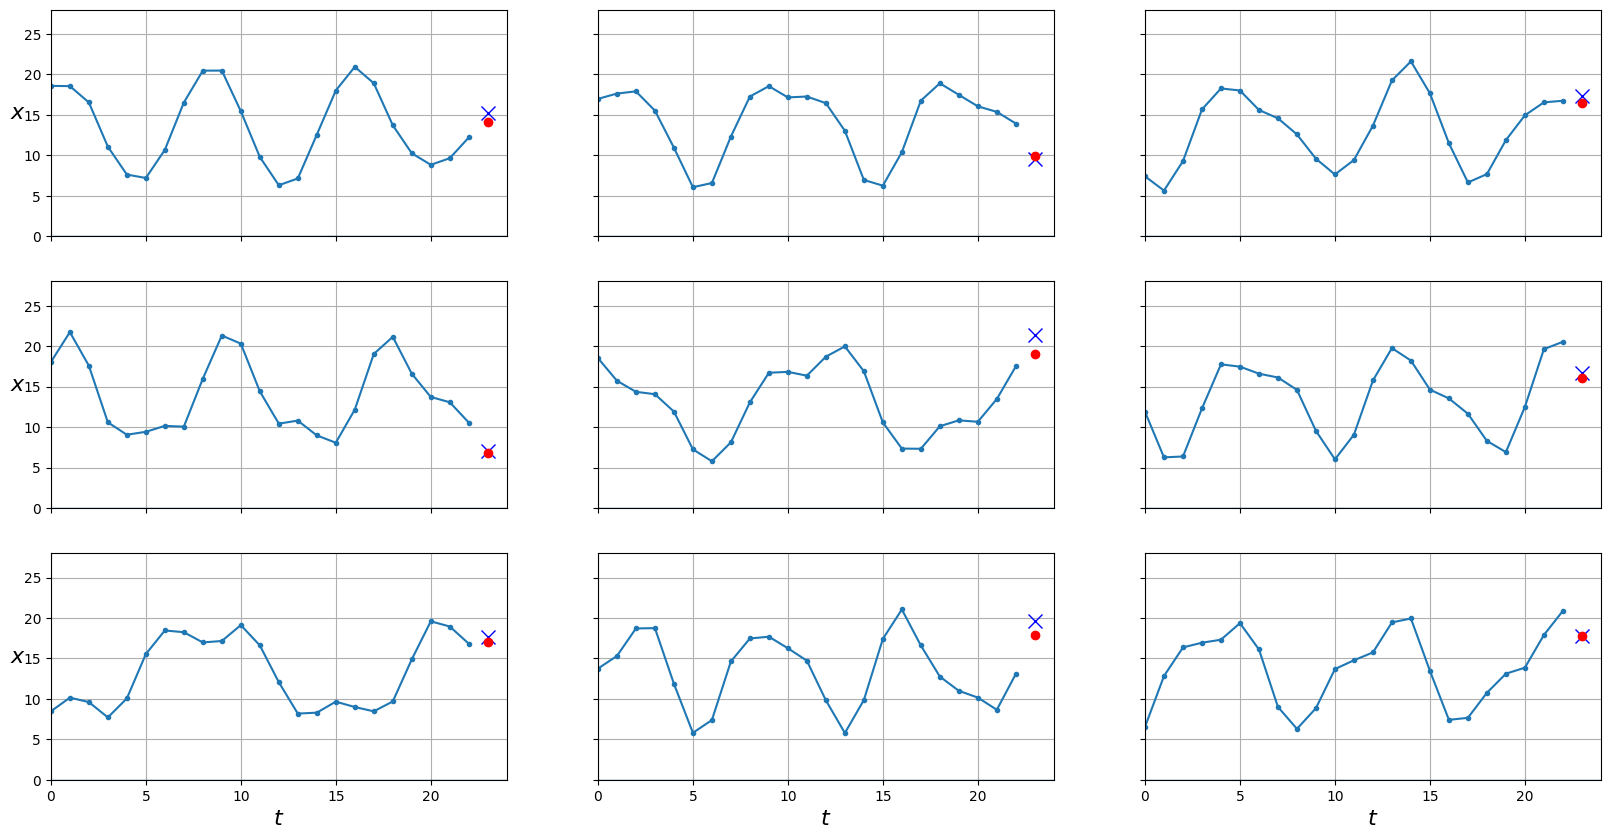

0.007825616

In [ ]:
from sklearn.metrics import mean_squared_error
y_pred = predict(rnn, dataloader['test'])

y_pred_transformada = transformar_tensor(y_pred)

plot_series(X_test_transformada, y_test_transformada, y_pred_transformada.cpu().numpy())
mean_squared_error(y_test, y_pred.cpu())

----------------------------------
## Varios Valores

In [ ]:
n_steps = 23
series = generate_time_series(365, n_steps + 10)#10 datos dfe predicicion para todas las y 
X_train, Y_train = series[:255, :n_steps], series[:255, -10:, 0]
X_valid, Y_valid = series[255:328, :n_steps], series[255:328, -10:, 0]
X_test, Y_test = series[328:, :n_steps], series[328:, -10:, 0]
# X_train.shape, Y_train.shape

dataset = {
    'train': TimeSeriesDataset(X_train, Y_train),
    'eval': TimeSeriesDataset(X_valid, Y_valid),
    'test': TimeSeriesDataset(X_test, Y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

In [ ]:
def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
  r, c = 2, 2
  fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
  for row in range(r):
    for col in range(c):
        plt.sca(axes[row][col])
        ix = col + row*c
        plt.plot(series[ix, :], ".-")
        if y is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
        if y_pred is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
        if y_pred_std is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
        plt.grid(True)
        plt.hlines(0, 0, 100, linewidth=1)
        plt.axis([0, len(series[ix, :])+len(y[ix]), 0, 28])
        if x_label and row == r - 1:
          plt.xlabel(x_label, fontsize=16)
        if y_label and col == 0:
          plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.show()

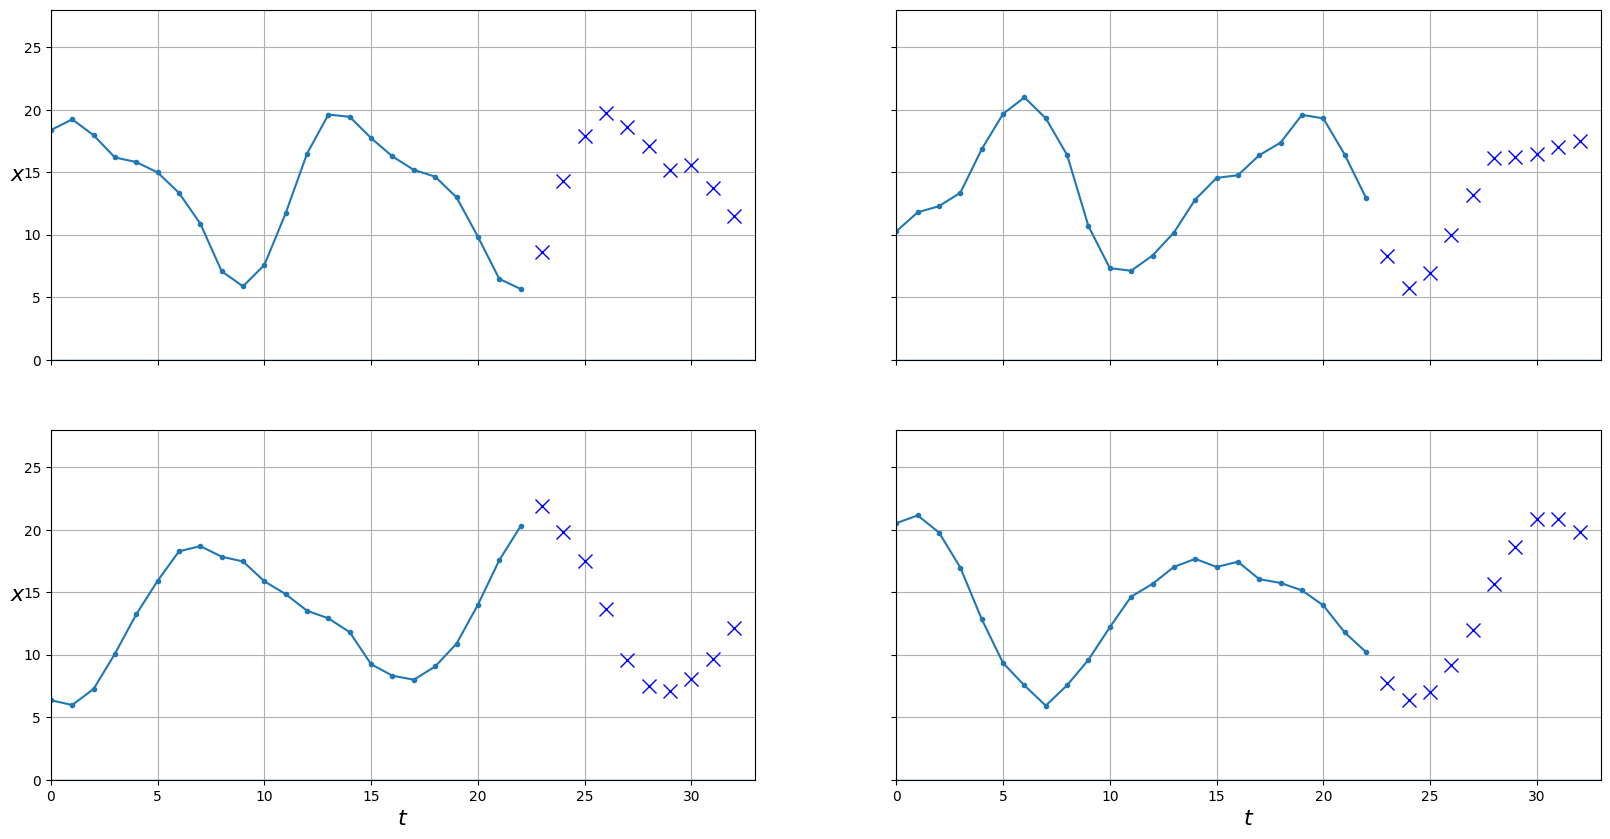

In [ ]:
X_test_transformada = transformar_tensor(X_test)
Y_test_transformada = transformar_tensor(Y_test)

plot_series(X_test_transformada, Y_test_transformada)

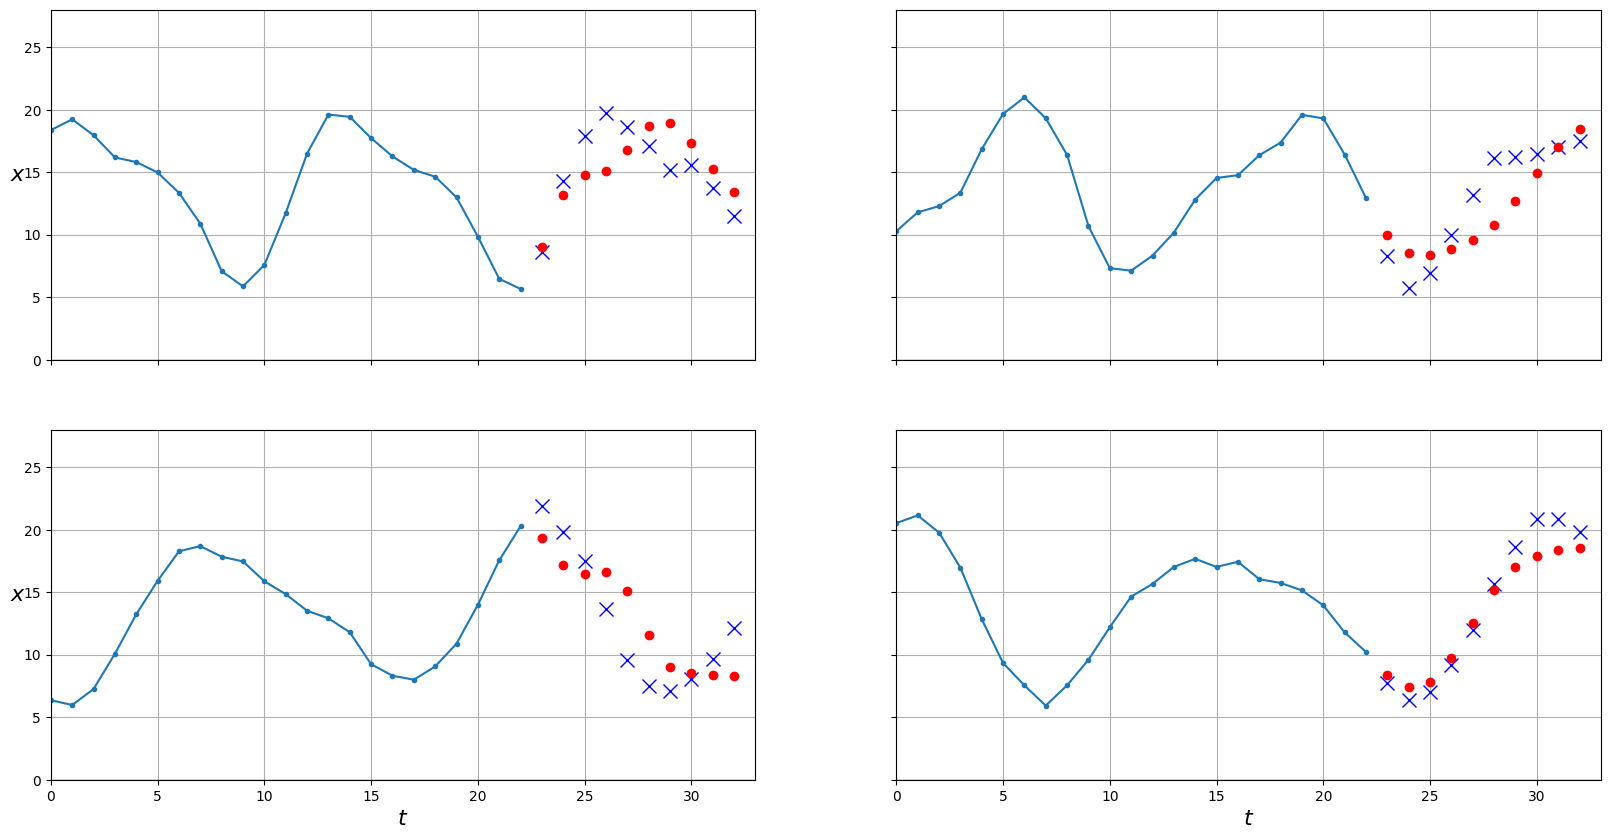

0.033851516

In [ ]:
X = X_test
for step_ahead in range(10):
    inputs = torch.from_numpy(X[:, step_ahead:]).unsqueeze(0)
    y_pred_one = predict(rnn, inputs).cpu().numpy()
    X = np.concatenate([X, y_pred_one[:, np.newaxis, :]], axis=1)

y_pred = X[:, n_steps:, -1]

y_pred_transformada = transformar_tensor(y_pred)

plot_series(X_test_transformada, Y_test_transformada, y_pred_transformada)
mean_squared_error(Y_test, y_pred)

# Deep RNN

In [ ]:
class DeepRNN(torch.nn.Module):
  def __init__(self, n_out=10):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=220, num_layers=2, batch_first=True)
    self.fc = torch.nn.Linear(220, n_out)

  def forward(self, x):
    x, h = self.rnn(x) 
    x = self.fc(x[:,-1])
    return x

In [ ]:
rnn = DeepRNN()
fit(rnn, dataloader)

loss 0.01682 val_loss 0.01676: 100%|██████████| 10/10 [00:40<00:00,  4.08s/it]


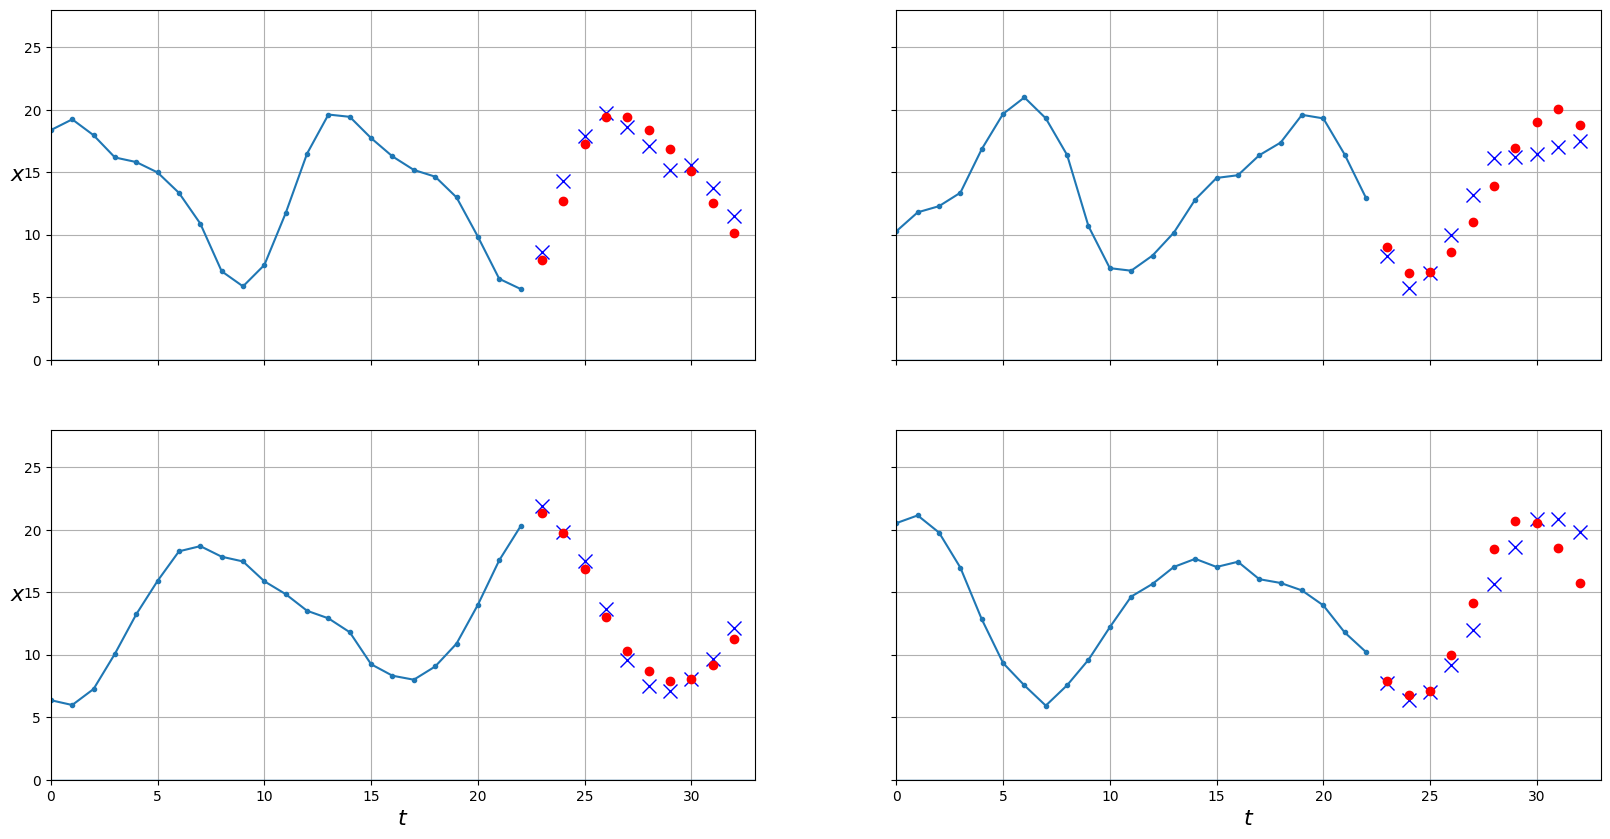

0.016330648

In [ ]:
y_pred = predict(rnn, dataloader['test'])

Y_pred_transformada = transformar_tensor(y_pred)

plot_series(X_test_transformada, Y_test_transformada, Y_pred_transformada.cpu().numpy())
mean_squared_error(Y_test, y_pred.cpu())

## Mejorando los datos

In [ ]:
# n_steps = 23
# series = generate_time_series(8280, n_steps + 10)
# X_train, Y_train = series[:5800, :n_steps], series[:5800, -10:, 0]
# X_valid, Y_valid = series[5800:7500, :n_steps], series[5800:7500, -10:, 0]
# X_test, Y_test = series[7500:, :n_steps], series[7500:, -10:, 0]

n_steps = 23
X_train = series[:5800, :n_steps]
X_valid = series[5800:7500, :n_steps]
X_test = series[7500:, :n_steps]
Y = np.empty((8280, n_steps, 10), dtype=np.float32)
for step_ahead in range(1, 10 + 1):
    Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]
    # Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:5800]
Y_valid = Y[5800:7500]
Y_test = Y[7500:]


dataset = {
    'train': TimeSeriesDataset(X_train, Y_train),
    'eval': TimeSeriesDataset(X_valid, Y_valid),
    'test': TimeSeriesDataset(X_test, Y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

In [ ]:
Y.shape

(8280, 23, 10)

In [ ]:
class DeepRNN(torch.nn.Module):
  def __init__(self, n_out=10):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=200, num_layers=2, batch_first=True)
    self.fc = torch.nn.Linear(200, n_out)

  def forward(self, x):
    x, h = self.rnn(x) 
    # print('\n',x.shape, '<------')
    # [ Batch, time steps, features ] --> [ Batch x time steps, features ]
    # print(x.size(-1), '<------')
    
    x_reshaped = x.contiguous().view(-1, x.size(-1))
    # print(x_reshaped.shape, '<------')
    # print("##"*30, '<------')
    y = self.fc(x_reshaped)
    # [ Batch x time steps, features ] --> [ Batch, time steps, features ]
    y = y.contiguous().view(x.size(0), -1, y.size(-1))
    return y

Como solo nos interesan los últimos 10 valores, calcularemos nuestra métricas solo para estos valores.

In [ ]:
def fit(model, dataloader, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    bar = tqdm(range(1, epochs+1))
    for epoch in bar:
        model.train()
        train_loss = []
        train_loss2 = []
        for batch in dataloader['train']:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            train_loss2.append((y[:,-1] - y_hat[:,-1]).pow(2).mean().item())
        model.eval()
        eval_loss = []
        eval_loss2 = []
        with torch.no_grad():
            for batch in dataloader['eval']:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
                eval_loss2.append((y[:,-1] - y_hat[:,-1]).pow(2).mean().item())
        bar.set_description(f"loss {np.mean(train_loss):.5f} loss_last_step {np.mean(train_loss2):.5f} val_loss {np.mean(eval_loss):.5f} val_loss_last_step {np.mean(eval_loss2):.5f}")
        

In [ ]:
rnn = DeepRNN()
fit(rnn, dataloader)

loss 0.03581 loss_last_step 0.01164 val_loss 0.03408 val_loss_last_step 0.00972: 100%|██████████| 10/10 [00:32<00:00,  3.29s/it]


In [ ]:
def scale_tensor(tensor, new_min, new_max):
    """
    Escala los valores de un tensor a un nuevo rango de valores.

    Args:
        tensor (torch.Tensor): El tensor original.
        new_min (float): El nuevo valor mínimo del rango.
        new_max (float): El nuevo valor máximo del rango.

    Returns:
        torch.Tensor: El tensor escalado.
    """
    # Obtener los valores mínimo y máximo del tensor original
    min_val = torch.min(tensor)
    max_val = torch.max(tensor)

    # Escalar los valores del tensor al nuevo rango
    scaled_tensor = ((tensor - min_val) / (max_val - min_val)) * (new_max - new_min) + new_min

    return scaled_tensor

torch.Size([780, 23, 10])


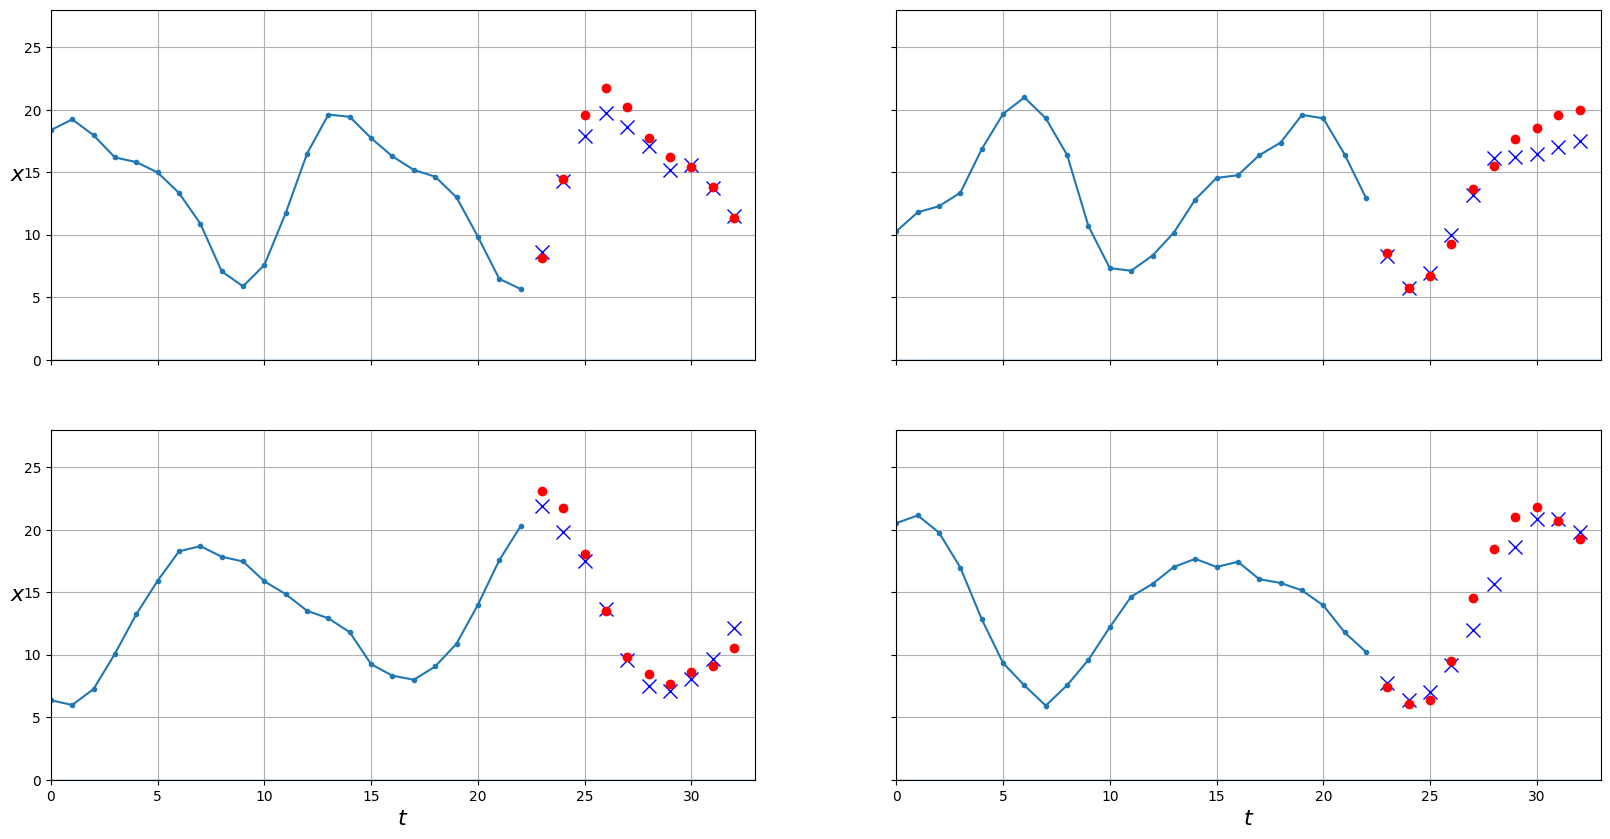

0.0095019415

In [ ]:
y_pred = predict(rnn, dataloader['test'])

y_pred_scaled = scale_tensor(y_pred, 2, 25)
print(y_pred_scaled.shape)

X_test_transformada = transformar_tensor(X_test)
Y_test_transformada = transformar_tensor(Y_test)

plot_series(X_test_transformada, Y_test_transformada[:,-1], y_pred_scaled[:,-1].cpu().numpy())
mean_squared_error(Y_test[:,-1], y_pred[:,-1].cpu())

## Intérvalos de Confianza

In [ ]:
class DeepRNN(torch.nn.Module):
  def __init__(self, n_out=10, dropout=0):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=200, num_layers=2, batch_first=True, dropout=dropout)
    self.fc = torch.nn.Linear(200, n_out)

  def forward(self, x):
    x, h = self.rnn(x) 
    # [ Batch, time steps, features ] --> [ Batch x time steps, features ]
    x_reshaped = x.contiguous().view(-1, x.size(-1))
    y = self.fc(x_reshaped)
    # [ Batch x time steps, features ] --> [ Batch, time steps, features ]
    y = y.contiguous().view(x.size(0), -1, y.size(-1))
    return y

In [ ]:
rnn = DeepRNN(dropout=0.3)
fit(rnn, dataloader)

loss 0.03998 loss_last_step 0.01912 val_loss 0.03841 val_loss_last_step 0.01698: 100%|██████████| 10/10 [00:38<00:00,  3.85s/it]


In [ ]:
def predict(model, dataloader):
    # activar dropout para evaluación !
    model.train() # lo normal aquí es poner model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [ ]:
y_preds = np.stack([predict(rnn, dataloader['test']).cpu().numpy() for sample in range(100)])
y_pred = y_preds.mean(axis=0)
y_pred_std = y_preds.std(axis=0)

In [ ]:
y_pred_transformada1 = transformar_tensor(y_pred)
y_pred_std_transformada1 = transformar_tensor(y_pred_std)

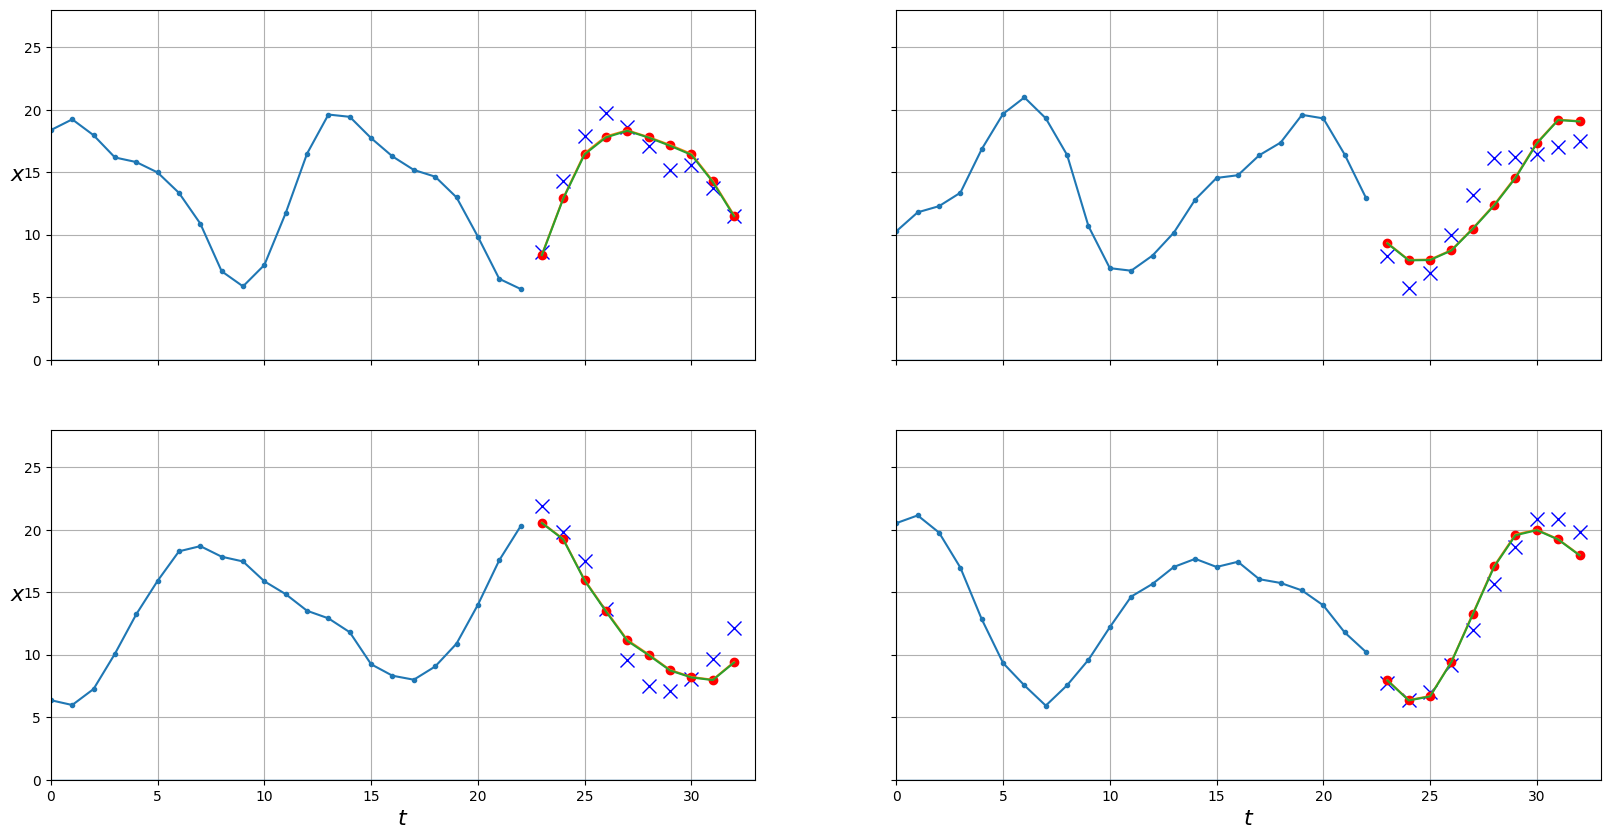

0.016234161

In [ ]:
plot_series(X_test_transformada, Y_test_transformada[:,-1], y_pred_transformada1[:,-1], y_pred_std[:, -1])
mean_squared_error(Y_test[:,-1], y_pred[:,-1])

## LSTM


In [ ]:
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    bar = tqdm(range(1, epochs+1))
    for epoch in bar:
        model.train()
        train_loss = []
        train_loss2 = []
        for batch in dataloader['train']:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            train_loss2.append((y[:,-1] - y_hat[:,-1]).pow(2).mean().item())
        model.eval()
        eval_loss = []
        eval_loss2 = []
        with torch.no_grad():
            for batch in dataloader['eval']:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
                eval_loss2.append((y[:,-1] - y_hat[:,-1]).pow(2).mean().item())
        bar.set_description(f"loss {np.mean(train_loss):.5f} loss_last_step {np.mean(train_loss2):.5f} val_loss {np.mean(eval_loss):.5f} val_loss_last_step {np.mean(eval_loss2):.5f}")

def predict(model, dataloader):
    model.eval() 
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [ ]:
class LSTM(DeepRNN):
  def __init__(self, n_out=10, dropout=0):
    super().__init__()
    self.rnn = torch.nn.LSTM(input_size=1, hidden_size=200, num_layers=2, dropout=dropout, batch_first=True)
    
lstm = LSTM()

In [ ]:
# parámetros en inputs (W_ii|W_if|W_ig|W_io)
# 4 matrices, 1 para cada *gate* 

lstm.rnn.weight_ih_l0.shape, lstm.rnn.bias_ih_l0.shape

(torch.Size([800, 1]), torch.Size([800]))

In [ ]:
# parámetros en capa oculta (W_ii|W_if|W_ig|W_io)
# 4 matrices, 1 para cada *gate* 

lstm.rnn.weight_hh_l0.shape, lstm.rnn.bias_hh_l0.shape

(torch.Size([800, 200]), torch.Size([800]))

In [ ]:
# salida y capas ocultas (short term y long term)

output, (h, c) = lstm.rnn(torch.randn(10, 50, 1))

# dims -> [num_layers, batch_size, len_seq]
h.shape, c.shape

(torch.Size([2, 10, 200]), torch.Size([2, 10, 200]))

In [ ]:
lstm = LSTM()
fit(lstm, dataloader)

loss 0.03862 loss_last_step 0.01565 val_loss 0.03915 val_loss_last_step 0.01608: 100%|██████████| 10/10 [01:54<00:00, 11.46s/it]


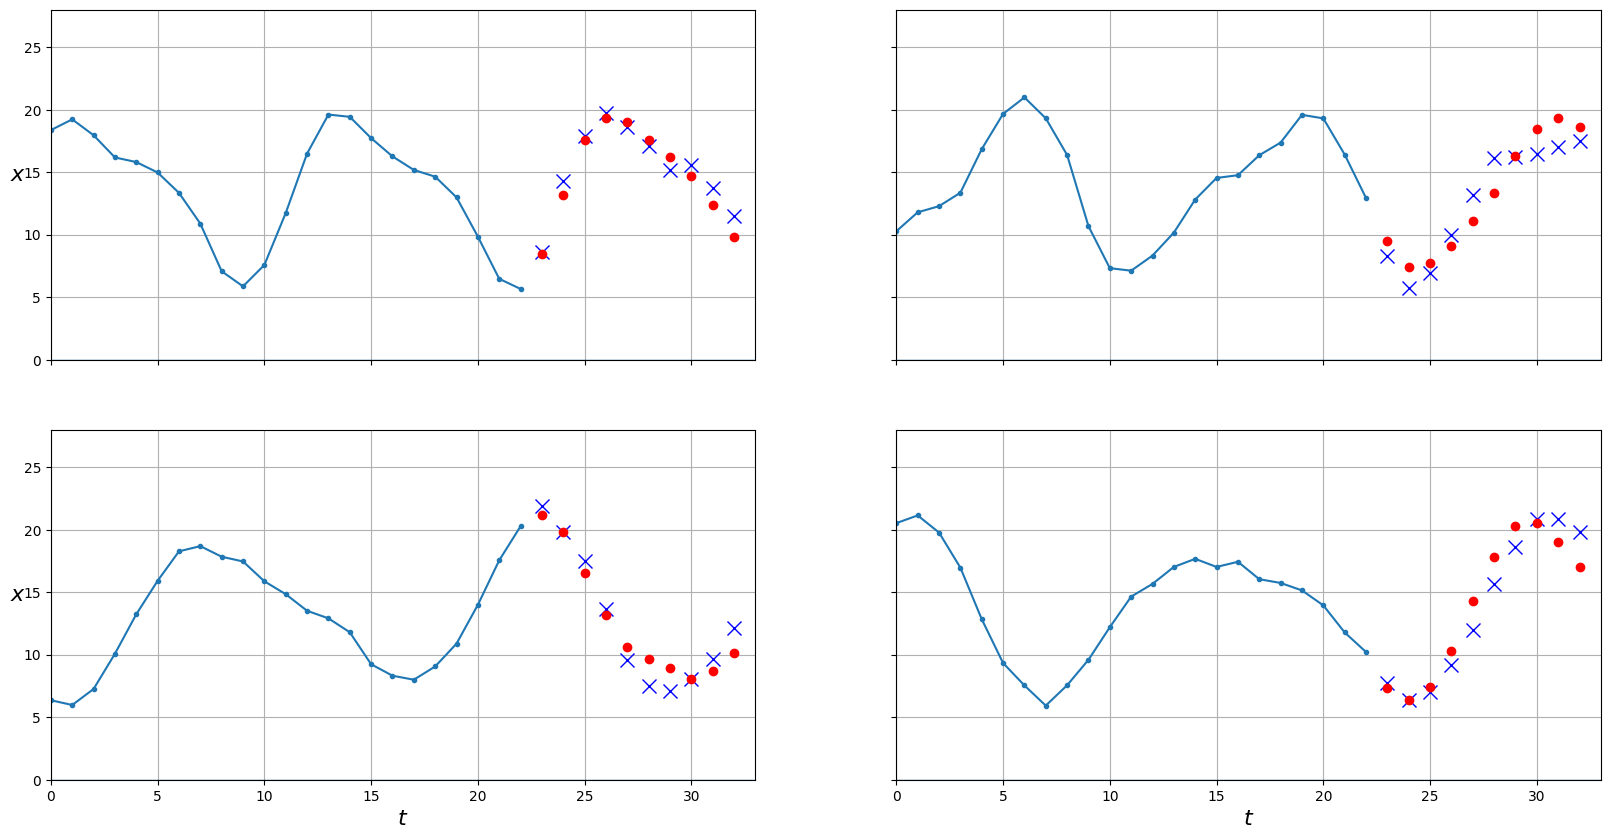

0.015409976

In [ ]:
y_pred = predict(lstm, dataloader['test'])

y_pred_transformada1 = transformar_tensor(y_pred)

plot_series(X_test_transformada, Y_test_transformada[:,-1], y_pred_transformada1[:,-1].cpu().numpy())
mean_squared_error(Y_test[:,-1], y_pred[:,-1].cpu())

## GRU

In [ ]:
class GRU(DeepRNN):
  def __init__(self, n_out=10, dropout=0):
    super().__init__()
    self.rnn = torch.nn.GRU(input_size=1, hidden_size=200, num_layers=3, dropout=dropout, batch_first=True)
    
gru = GRU()

In [ ]:
gru = GRU()
fit(gru, dataloader)

loss 0.03052 loss_last_step 0.00773 val_loss 0.02970 val_loss_last_step 0.00670: 100%|██████████| 10/10 [02:27<00:00, 14.78s/it]


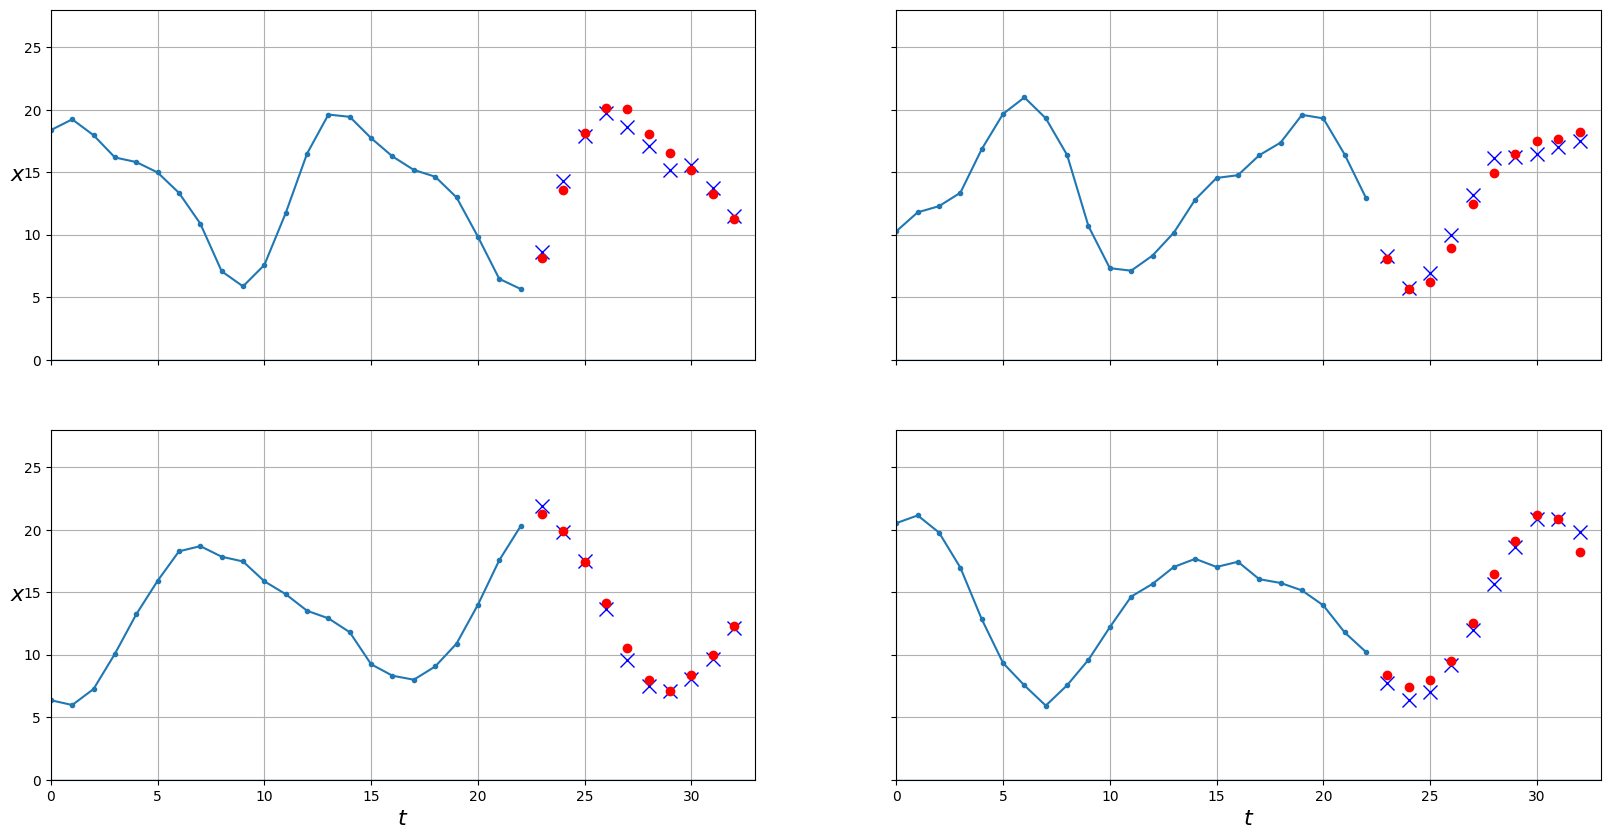

0.00648261

In [ ]:
y_pred = predict(gru, dataloader['test'])

y_pred_transformada1 = transformar_tensor(y_pred)

plot_series(X_test_transformada, Y_test_transformada[:,-1], y_pred_transformada1[:,-1].cpu().numpy())
mean_squared_error(Y_test[:,-1], y_pred[:,-1].cpu())